In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))

In [2]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from matplotlib import pyplot as plt
%matplotlib inline

graph_05_06_02


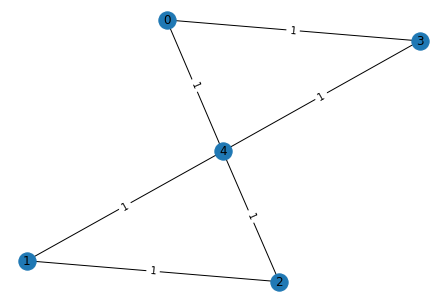

In [3]:
graph = generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
print(graph.name)
max_cut.draw()

In [4]:
step_size = 0.1
gamma_range = np.arange(0, np.pi, step_size)
beta_range = np.arange(0, np.pi, step_size)

In [5]:
a_gamma, b_beta = np.meshgrid(gamma_range, beta_range)
a_gamma[0,0]

0.0

In [6]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i,j,w in graph.edges.data('weight'):
        if x[i] != x[j]:
            obj -= w
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [7]:
quantum_instance = QuantumInstance(
                    #backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    backend=provider.get_backend('ibmq_sydney'),
                    shots=SHOTS,
                    measurement_error_mitigation_cls=CompleteMeasFitter,
                    measurement_error_mitigation_shots=SHOTS,
                )
qaoa = QAOA(
            optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=1
            )

op, offset = max_cut_qubo.to_ising()

In [8]:
def create_cirucit(gamma,beta):
    circuits = qaoa.construct_circuit([gamma,beta], operator=op)
    circuit = circuits[0]
    circuit.measure_all()
    return circuit

In [9]:
landscape = np.zeros(a_gamma.shape)
print(landscape)
len(landscape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


32

In [10]:

for i in range(0, len(landscape)):
    circuits = []
    for j in range(0, len(landscape)):
        # create circuits for entire row 
        circuit = create_cirucit(a_gamma[i][j], b_beta[i][j])
        circuits.append(circuit)
    
    # create one job with circuits 
    job_name = f"{graph.name}_em_row_{i}"
    job = quantum_instance.execute(circuits)
    #job.update_name(job_name)
    print(job_name)
    
    # add results to landscape 
    j = 0
    for count in job.get_counts():
        try:
            mean = compute_expectation(count, graph)
            landscape[i,j % 32] = mean
            j += 1
        except Exception as e:
            print(e)

graph_05_06_02_em_row_0
graph_05_06_02_em_row_1
graph_05_06_02_em_row_2
graph_05_06_02_em_row_3
graph_05_06_02_em_row_4
graph_05_06_02_em_row_5
graph_05_06_02_em_row_6
graph_05_06_02_em_row_7
graph_05_06_02_em_row_8
graph_05_06_02_em_row_9
graph_05_06_02_em_row_10
graph_05_06_02_em_row_11
graph_05_06_02_em_row_12
graph_05_06_02_em_row_13
graph_05_06_02_em_row_14
graph_05_06_02_em_row_15
graph_05_06_02_em_row_16
graph_05_06_02_em_row_17
graph_05_06_02_em_row_18
graph_05_06_02_em_row_19
graph_05_06_02_em_row_20
graph_05_06_02_em_row_21
graph_05_06_02_em_row_22
graph_05_06_02_em_row_23
graph_05_06_02_em_row_24
graph_05_06_02_em_row_25


account._job_result_object_storage:WARNING:2021-10-08 18:25:42,161: An error occurred while sending download completion acknowledgement: "HTTPSConnectionPool(host='api-qcon.quantum-computing.ibm.com', port=443): Read timed out. (read timeout=None)"


graph_05_06_02_em_row_26
graph_05_06_02_em_row_27
graph_05_06_02_em_row_28
graph_05_06_02_em_row_30
graph_05_06_02_em_row_31


[[-2.99925    -2.9965     -3.00275    ... -2.94875    -2.974
  -2.99675   ]
 [-2.95386151 -2.99091591 -2.93665072 ... -3.06843932 -3.01210179
  -2.991413  ]
 [-2.99325    -2.932      -2.87475    ... -3.06975    -3.0415
  -2.9805    ]
 ...
 [-3.04943732 -3.03391381 -3.09592697 ... -2.68866255 -2.74452277
  -2.82955912]
 [-3.086      -3.05225    -3.10175    ... -2.801      -2.83175
  -2.952     ]
 [-3.07717321 -3.05222561 -3.08409122 ... -2.93021997 -2.9351989
  -2.99583172]]


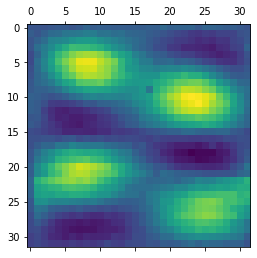

In [11]:
print(landscape)
plt.matshow(landscape)
plt.show()

In [12]:
#a_del = np.delete(landscape, 0, 0)


In [13]:
#a_del = np.delete(a_del, 16, 0)

In [14]:
#plt.matshow(a_del)
#plt.show()

In [15]:
# Mean of landscape
np.mean(landscape)

-2.8073153229872023

In [16]:
# Minimium 
np.min(landscape)

-3.3283491268172263

In [17]:
# Display Coordinates of Minimum 
np.unravel_index(np.argmin(landscape), landscape.shape)

(18, 23)

In [18]:
# Gamma and beta value of Minimium
gamma, beta = np.unravel_index(np.argmin(landscape), landscape.shape)
opt_gamma = gamma * step_size
opt_beta = beta * step_size
print(f"Opt.Gamma: {opt_gamma}, Opt.Beta: {opt_beta}")

Opt.Gamma: 1.8, Opt.Beta: 2.3000000000000003


In [19]:
# Save result matrix 
with open('landscape_sydney_butterfly_no_weights_em_results_2.npy', 'wb') as f:
    np.save(f, landscape)

In [20]:
import plotly.graph_objects as go

In [ ]:
# Plot landscape in 3D 
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)
fig = go.Figure(data=go.Surface(z=landscape, x=a_gamma, y=b_beta))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


fig.update_layout(title="QAOA with Qiskit Error Mitigation - MaxCut-Landscape", scene=dict(
    xaxis_title="γ",
    yaxis_title="β",
    zaxis_title="F(γ,β)"
))

In [ ]:
# Plot Heatmap 
fig = go.Figure(data=go.Heatmap(z=landscape, x=b_beta, y=a_gamma, type = 'heatmap', colorscale = 'viridis'))

# Update Layout
fig.update_layout(title="F(γ,β)", width=700, height=700, yaxis_title="β", xaxis_title="γ")

# Display Global Minimium 
fig.add_trace(
    go.Scatter(mode="markers", x=[opt_beta], y=[opt_gamma], marker_symbol=[204], text = [landscape[gamma,beta]],
                   marker_color="red",  hovertemplate="x: %{x}<br>y: %{y}<br> z: %{text:.2f}<extra></extra>", 
                   marker_line_width=1, marker_size=16))

In [ ]:
# Display Optimizer Results

# Display path 
#fig.add_trace(
#    go.Scatter(mode="lines", x=gammas, y=betas, marker_symbol=[200],
#                   marker_color="white", marker_line_width=1, marker_size=8)
#)

# Display start point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[0]], y=[betas[0]], marker_symbol=[204],
#                   marker_color="gray", 
#                   marker_line_width=1, marker_size=16))

# Display end point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[-1]], y=[betas[-1]], marker_symbol=[204],
#                   marker_color="green", 
#                   marker_line_width=1, marker_size=16))



In [28]:
# Plot Optimizer History
#fig = go.Figure(data=go.Scatter(x=counts, y=values))
#fig.update_layout(xaxis_title="Evaluation Counts", yaxis_title="Evaluated Mean", title="Optimizer")
#fig.show()